Epoch [10/100], Loss: 0.5422


C:\Users\danie\miniconda3\envs\danielfischer_portfolio\Lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
C:\Users\danie\miniconda3\envs\danielfischer_portfolio\Lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Epoch [20/100], Loss: 0.4187
Epoch [30/100], Loss: 0.3268
Epoch [40/100], Loss: 0.2603
Epoch [50/100], Loss: 0.2131
Epoch [60/100], Loss: 0.1800
Epoch [70/100], Loss: 0.1564
Epoch [80/100], Loss: 0.1389
Epoch [90/100], Loss: 0.1256
Epoch [100/100], Loss: 0.1151


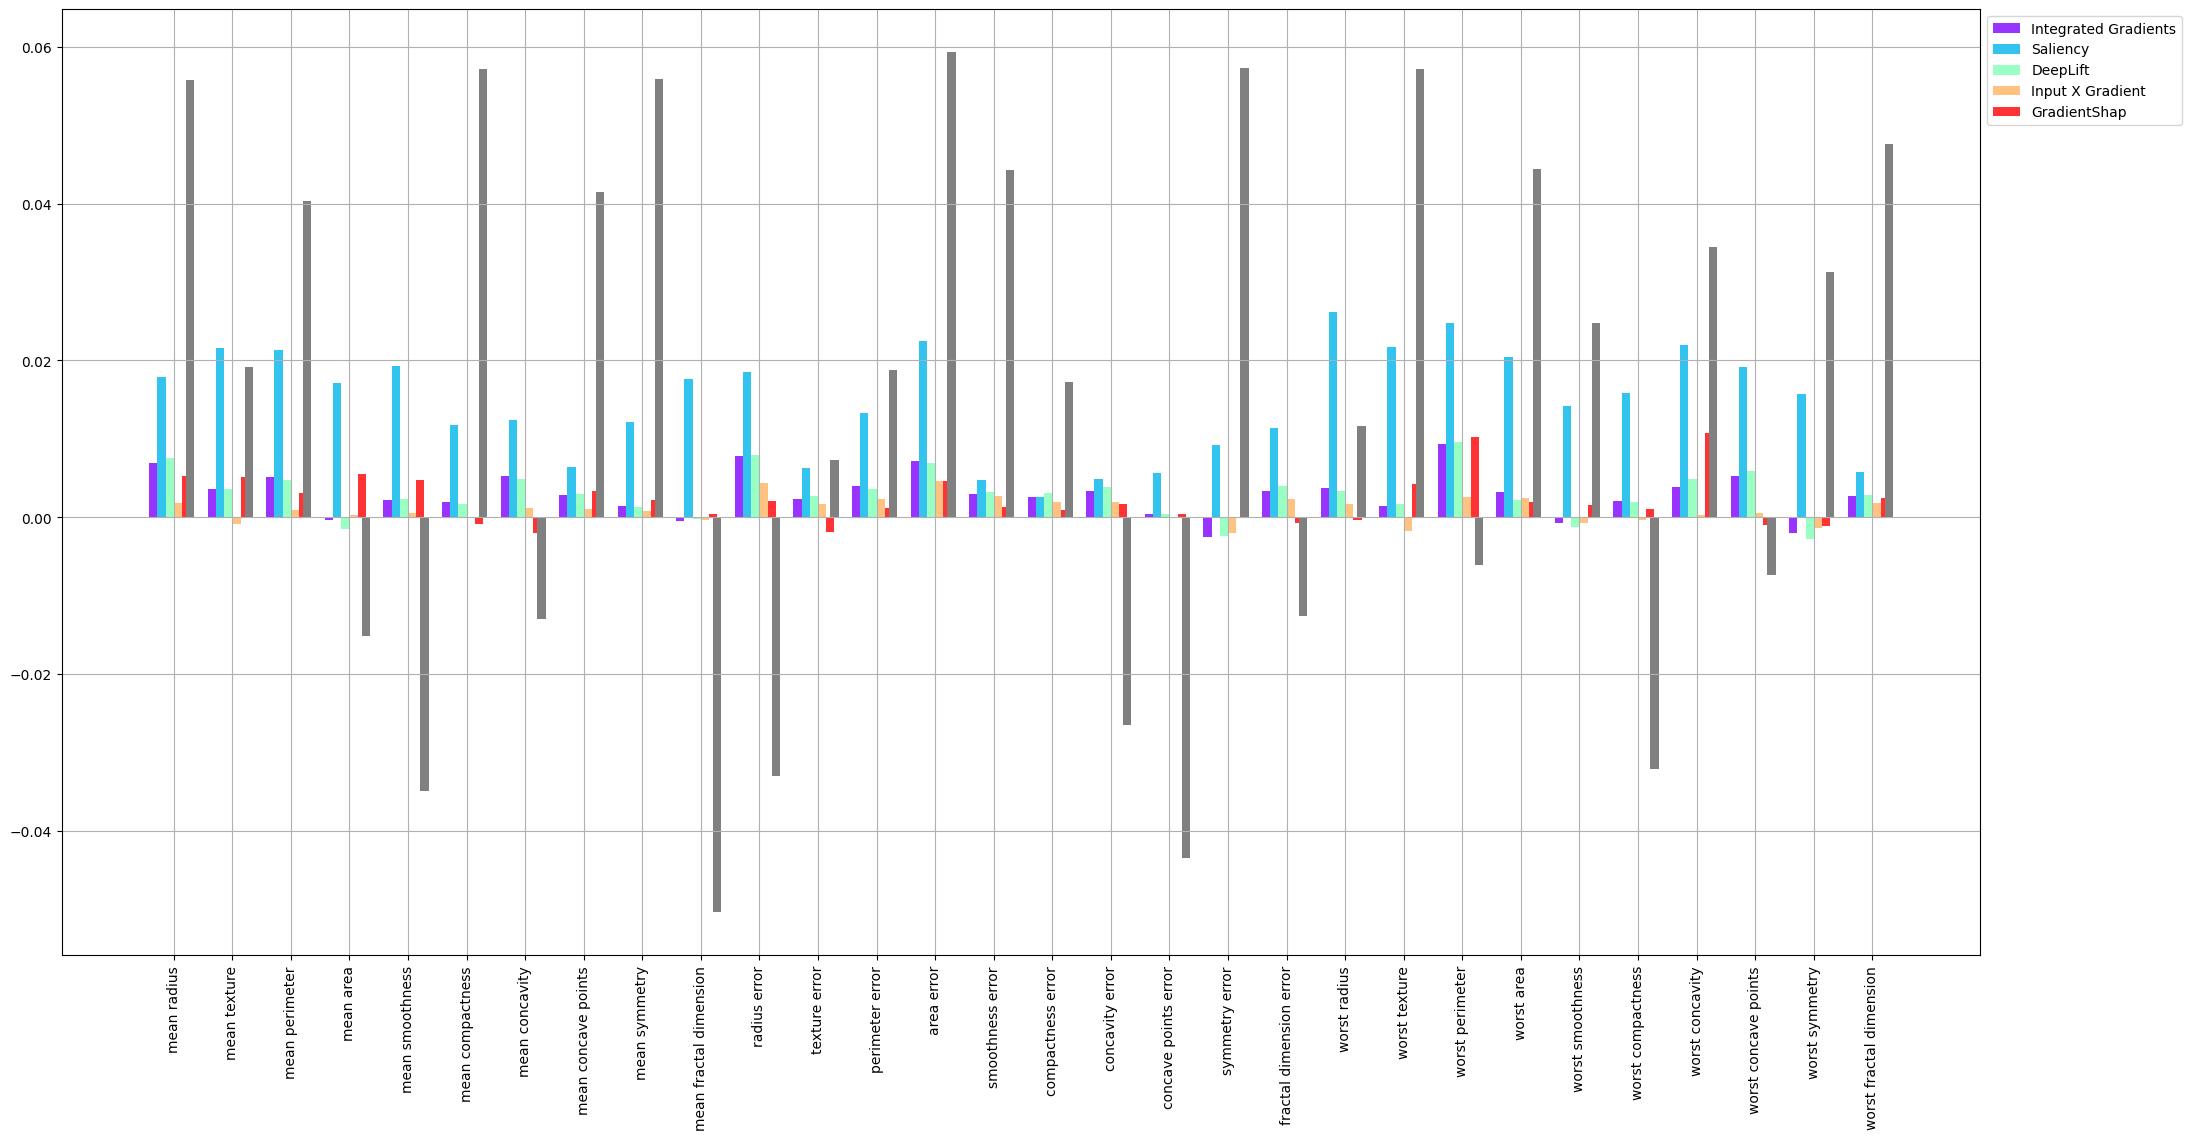

Accuracy on the test set: 0.9825


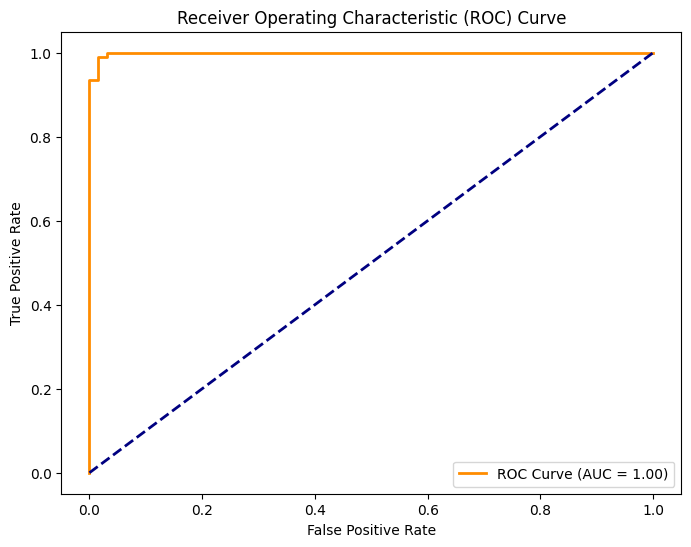

ROC AUC Score: 0.9988
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98        63
           1       0.99      0.98      0.99       108

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171


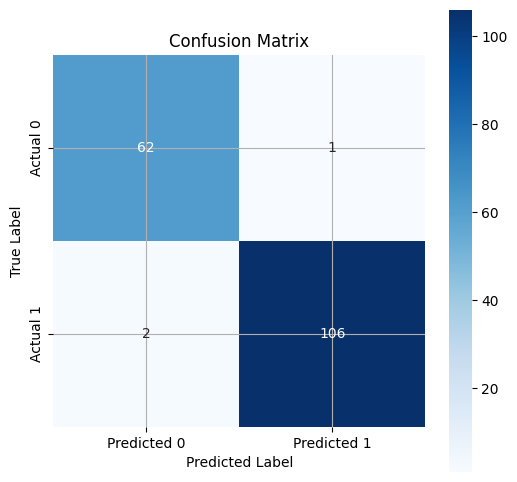

In [23]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from captum.attr import IntegratedGradients, Saliency, DeepLift, InputXGradient, GradientShap

#Setting seed
torch.manual_seed(96)

# Load breast cancer dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define the neural network architectures
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, requires_grad=True):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Instantiate the model
input_size = X_train.shape[1]
model = NeuralNetwork(input_size)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Instantiate the attribution methods
ig = IntegratedGradients(model)
saliency = Saliency(model)
deep_lift = DeepLift(model)
input_x_gradient = InputXGradient(model)
# Choose baselines for GradientShap
baselines = torch.randn_like(X_train_tensor)
gradient_shap = GradientShap(model)

# List of attribution methods and legends
attribution_methods = [ig, saliency, deep_lift, input_x_gradient, gradient_shap]
legends = ['Integrated Gradients', 'Saliency', 'DeepLift', 'Input X Gradient', 'GradientShap']

# Prepare attributions for visualization
x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = data.feature_names

# Define width and other necessary variables
width = 0.14
lin_weight = model.fc1.weight[0].detach().numpy()  # assuming fc1 is the first layer
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

# Training the model
epochs = 100

# Initialize a list to store colors for each method
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(attribution_methods))))
plt.figure(figsize=(20, 10))
ax = plt.subplot()

for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.view(-1, 1))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
        
   # Compute and log attributions to TensorBoard
    if (epoch + 1) % 10 == 0:
        for method, legend in zip(attribution_methods, legends):
            if method == gradient_shap:
                attributions = method.attribute(X_train_tensor, baselines=baselines, target=0)
            else:
                attributions = method.attribute(X_train_tensor, target=0)
    
            attributions = attributions.detach().numpy()
    
            # Plot attributions only for the last epoch
            if epoch == epochs - 1:
                color = next(colors)
                ax.bar(x_axis_data + (width / 2) + width * attribution_methods.index(method),
                       attributions.mean(axis=0),
                       width,
                       align='center',
                       alpha=0.8,
                       label=legend,
                       color=color)


ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 3 * width)
ax.set_xticklabels(x_axis_data_labels, rotation='vertical')  # Display names vertically

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend to the top left
plt.grid(True)  # Add a grid
plt.show()

# Evaluate the model on the test set
with torch.no_grad():
    model.eval()
    test_outputs = model(X_test_tensor)
    predicted_probs = test_outputs.numpy()
    predicted_labels = (test_outputs > 0.5).float().view(-1)

print(f'Accuracy on the test set: {accuracy:.4f}')

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, predicted_probs)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, predicted_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print(f'ROC AUC Score: {roc_auc:.4f}')

# Print and plot the classification report
classification_rep = classification_report(y_test, predicted_labels.numpy())
print("Classification Report:")
print(classification_rep)

# Plot confusion matrix
cm = confusion_matrix(y_test, predicted_labels.numpy())
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", square=True,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.grid(True)
plt.show()

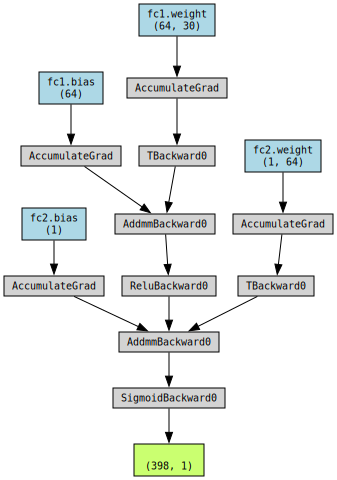

In [12]:
from torchviz import make_dot

# Visualize the model
model_visualization = make_dot(model(X_train_tensor), params=dict(model.named_parameters()))

# Save the visualization as PNG
model_visualization.format = 'png'
model_visualization.render(filename='model_architecture', format='png')

# Display the visualization
model_visualization

Epoch [10/200], Loss: 0.5422


C:\Users\danie\miniconda3\envs\danielfischer_portfolio\Lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
C:\Users\danie\miniconda3\envs\danielfischer_portfolio\Lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Epoch [20/200], Loss: 0.4187
Epoch [30/200], Loss: 0.3268
Epoch [40/200], Loss: 0.2603
Epoch [50/200], Loss: 0.2131
Epoch [60/200], Loss: 0.1800
Epoch [70/200], Loss: 0.1564
Epoch [80/200], Loss: 0.1389
Epoch [90/200], Loss: 0.1256
Epoch [100/200], Loss: 0.1151
Epoch [110/200], Loss: 0.1066
Epoch [120/200], Loss: 0.0995
Epoch [130/200], Loss: 0.0935
Epoch [140/200], Loss: 0.0884
Epoch [150/200], Loss: 0.0840
Epoch [160/200], Loss: 0.0801
Epoch [170/200], Loss: 0.0767
Epoch [180/200], Loss: 0.0736
Epoch [190/200], Loss: 0.0708
Epoch [200/200], Loss: 0.0682


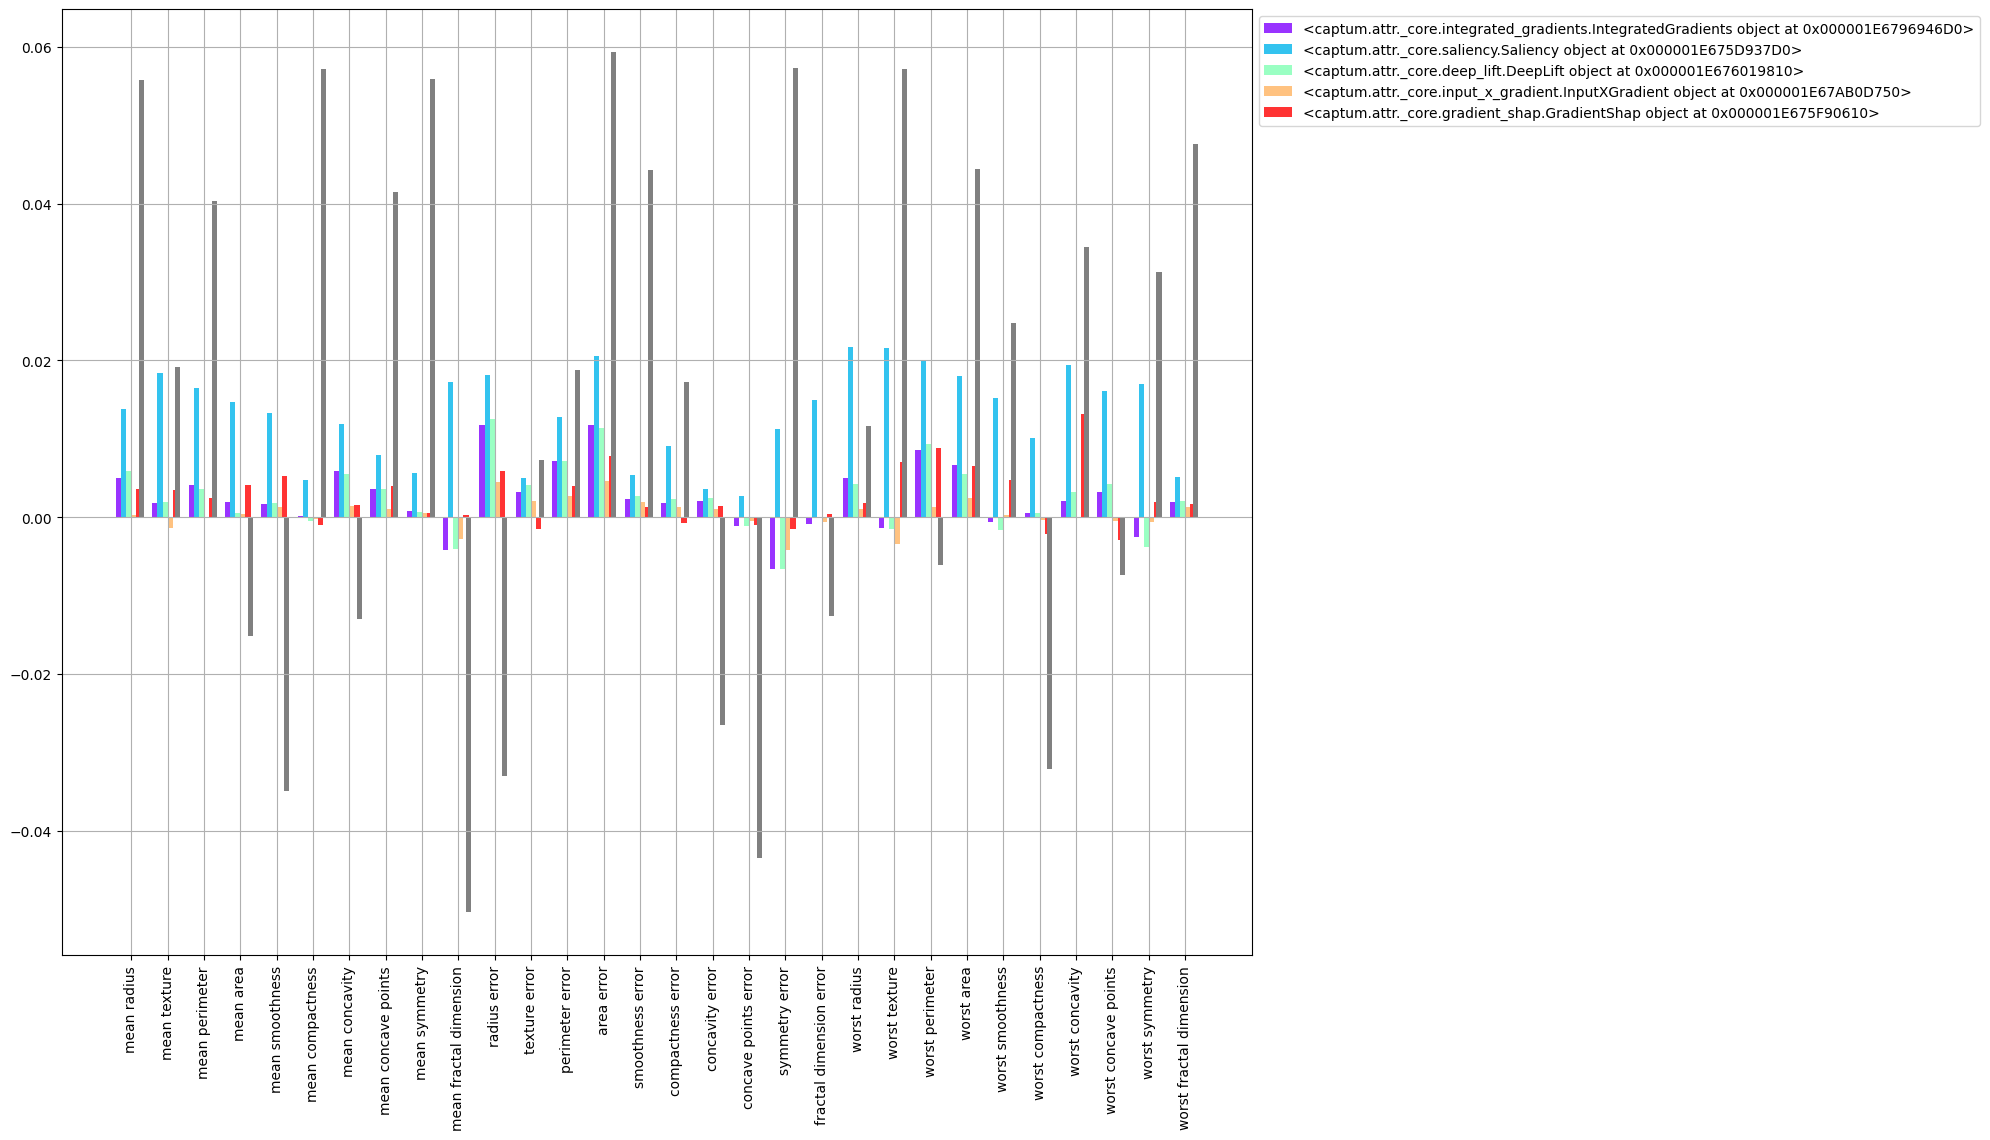

In [21]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from captum.attr import IntegratedGradients, Saliency, DeepLift, InputXGradient, GradientShap

# Setting seed
torch.manual_seed(96)

# Load breast cancer dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Instantiate the model
input_size = X_train.shape[1]
model = NeuralNetwork(input_size)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Instantiate the attribution methods
ig = IntegratedGradients(model)
saliency = Saliency(model)
deep_lift = DeepLift(model)
input_x_gradient = InputXGradient(model)
# Choose baselines for GradientShap
baselines = torch.randn_like(X_train_tensor)
gradient_shap = GradientShap(model)

# List of attribution methods
attribution_methods = [ig, saliency, deep_lift, input_x_gradient, gradient_shap]

# Prepare attributions for visualization
x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = data.feature_names

# Define width and other necessary variables
width = 0.14
lin_weight = model.fc1.weight[0].detach().numpy()  # assuming fc1 is the first layer
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

# Training the model
epochs = 200

# Initialize a list to store colors for each method
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(attribution_methods))))
plt.figure(figsize=(20, 10))
ax = plt.subplot()

# Initialize an empty list to store legends
all_legends = []

for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.view(-1, 1))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
        
   # Compute and log attributions to TensorBoard
    if (epoch + 1) % 10 == 0:
        for method in attribution_methods:
            if method == gradient_shap:
                attributions = method.attribute(X_train_tensor, baselines=baselines, target=0)
            else:
                attributions = method.attribute(X_train_tensor, target=0)
    
            attributions = attributions.detach().numpy()
    
            # Plot attributions only for the last epoch
            if epoch == epochs - 1:
                color = next(colors)
                ax.bar(x_axis_data + (width / 2) + width * attribution_methods.index(method),
                       attributions.mean(axis=0),
                       width,
                       align='center',
                       alpha=0.8,
                       color=color)
                
                # Append legend to the list
                all_legends.append(method)
            
# Add legend outside the loop
ax.legend(all_legends, loc='upper left', bbox_to_anchor=(1, 1))  # Move legend to the top left

ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 3 * width)
ax.set_xticklabels(x_axis_data_labels, rotation='vertical')  # Display names vertically

plt.grid(True)  # Add a grid
plt.show()

# ... (rest of the code)
